# Make all PDF files to dataframe

In [14]:
# my_roots_list//lippincottlibrary.wordpress.com/2020/02/05/python-find-files-with-os-walk/
import os
def list_files(filepath, filetype):
    paths = []
    roots = []
    path1 = []
    file1 = []
    path = ''
    for root, dirs, files in os.walk(filepath):
        for file in files:
            if file.lower().endswith(filetype.lower()) and os.path.isfile(os.path.join(root, file)):
                paths.append(os.path.join(root, file))
                roots.append(root)
                path = os.path.join(root, file)
                path1.append(path[path.find('\\',4,len(path)):])
                file1.append(file)
    return(roots,path1,paths,file1)

In [15]:
my_roots_list,my_path_list,my_files_list,my_filenames_list = list_files('.\\2021', '.pdf')
import pandas as pd
file_df = pd.concat([pd.Series(my_files_list),pd.Series(my_roots_list),pd.Series(my_path_list),pd.Series(my_filenames_list)],axis=1)
file_df.columns = ['file','dir','path','file_name']
file_df['name'] = file_df.file_name.str[:-4]

In [10]:
# https://mkyong.com/python/python-how-to-delete-a-file-or-folder/
# You should change 'test' to your preferred folder.
import shutil
MYDIR = (".\\images")
def makedir(MYDIR):
    CHECK_FOLDER = os.path.isdir(MYDIR)

    # If folder doesn't exist, then create it.
    if not CHECK_FOLDER:
        os.makedirs(MYDIR)
        print("created folder : ", MYDIR)

    else:
        shutil.rmtree(MYDIR)
        print(MYDIR, "folder already exists and re-created")
        os.mkdir(MYDIR)

In [17]:
makedir(MYDIR)

.\images folder already exists and re-created


In [14]:
# https://www.analyticsvidhya.com/blog/2021/05/how-to-use-progress-bars-in-python/
from tqdm.notebook import tqdm_notebook

In [19]:
from PIL import Image 
Image.MAX_IMAGE_PIXELS = 1000000000
from pdf2image import convert_from_path
st = pd.Timestamp.now()
# for i in file_df.index:
for i in tqdm_notebook(range(len(file_df))):
    pdfs = file_df.file[i]
    pages = convert_from_path(pdfs, 350)
    j = 1
    for page in pages:
        image_name = '.\\images' + '\\' + file_df.name[i] + '_page'  + str(j) + '.jpg'
#         image_name = '.\\images' + file_df.dir[i][1:]+ '\\' + file_df.name[i] + '_page'  + str(j) + '.jpg'
#         image_name = './images' + file_df.dir[i].str[1:] + '/' + file_df.name[i] + '_page'  + str(j) + '.jpg'
        page.save(image_name, "JPEG")
        j += 1   
print(f'Time2SaveImages {pd.Timestamp.now()-st}')

  0%|          | 0/55 [00:00<?, ?it/s]

Time2SaveImages 0 days 00:02:02.891476


# CV2 read Thai file name

In [20]:
# https://stackoverflow.com/questions/20831612/getting-the-bounding-box-of-the-recognized-words-using-python-tesseract
import pandas as pd
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
from pytesseract import Output
import matplotlib.pyplot as plt
import cv2
import os

In [12]:
# https://stackoverflow.com/a/43185606
# https://diewland.medium.com/python-cv2-%E0%B9%83%E0%B8%99-windows-%E0%B8%AD%E0%B9%88%E0%B8%B2%E0%B8%99%E0%B9%84%E0%B8%9F%E0%B8%A5%E0%B9%8C%E0%B8%A0%E0%B8%B2%E0%B8%A9%E0%B8%B2%E0%B9%84%E0%B8%97%E0%B8%A2%E0%B9%84%E0%B8%A1%E0%B9%88%E0%B9%84%E0%B8%94%E0%B9%89-f688a4747070
import numpy as np
import cv2
def cv2_imread_win(img_filepath, np):
    with open(img_filepath, "rb") as stream:
        bytes = bytearray(stream.read())
        numpyarray = np.asarray(bytes, dtype=np.uint8)
        return cv2.imdecode(numpyarray, cv2.IMREAD_UNCHANGED)

In [22]:
def create_rectangle_dataframe(image,file,marked_folder):
#     img0 = cv2.imread(image)
    img0 = cv2_imread_win(image,np)
    img = img0.copy()
    df = pd.DataFrame()
    d = pytesseract.image_to_data(img, output_type=Output.DICT, config='--psm 12')
    n_boxes = len(d['level'])
    k = 0
    for i in range(n_boxes):
        l = []
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    #     text = d['text'][i]
        text = d['text'][i].replace('—','-').replace('~','-')
        if len(text.strip())>5 :
            k = k+1
            l = pd.Series([file, k, text, x, y, x+w, y+h])
            df = df.append(l,ignore_index=True)
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(img, '['+str(k)+']'+text, (x, y - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
    #         print(i,l.tolist())
#     plt.imshow(img)
#     plt.imsave('box_in_circle.jpg',img)
#     plt.imsave(f'.\\data_and_imagesmarked\\{file}',img)
    plt.imsave(marked_folder+file,img)
    return(df)
        #     print(text, x, y, x+w, y+h)

In [23]:
marked_folder = r'.\\data_and_imagesmarked\\'
makedir(MYDIR=marked_folder)

.\\data_and_imagesmarked\\ folder already exists and re-created


In [24]:
df = pd.DataFrame()
for root, dirs, files in os.walk('.\\images'):
        for file in tqdm_notebook(files):
            image = os.path.join(root, file)
            df0 = create_rectangle_dataframe(image,file,marked_folder)
            df = df.append(df0)
df.columns = ['file_name','id','text','x1','y1','x2','y2']

  0%|          | 0/55 [00:00<?, ?it/s]

In [25]:
df.columns = ['file_name','id','text','x1','y1','x2','y2']
df.to_excel('text_location.xlsx')

# Lookup text to search on drawing

In [16]:
import pandas as pd
df = pd.read_excel('text_location.xlsx',index_col=[0])

In [17]:
import matplotlib.pyplot as plt

In [32]:
# lookup = '15E020'
# lookup = '15C001'
lookup = '15C003'

def find_text(lookup):
    return df[df.text.str.contains(lookup,na=False)]

In [33]:
lookup_df = find_text(lookup=lookup)
# lookup_df['id'] = lookup_df['id'].astype(int)
lookup_df = lookup_df.astype({'id':'int','x1':'int','x2':'int','y1':'int','y2':'int'})

In [34]:
lookup_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 179 to 110
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  13 non-null     object
 1   id         13 non-null     int32 
 2   text       13 non-null     object
 3   x1         13 non-null     int32 
 4   y1         13 non-null     int32 
 5   x2         13 non-null     int32 
 6   y2         13 non-null     int32 
dtypes: int32(5), object(2)
memory usage: 572.0+ bytes


In [35]:
lookup_file_name = lookup_df.groupby('file_name')['file_name'].count()
lookup_file_name = lookup_file_name.index
# lookup_file_name = lookup_file_name.values
lookup_file_name

Index(['69-P-1-01-500-3-1_page1.jpg', '69-P-1-15-010-3-9_page1.jpg',
       '69-P-1-15-011-3-11_page1.jpg', '69-P-1-15-012-3-6_page1.jpg',
       '69-P-1-15-030-3-8_page1.jpg', '69-P-1-15-033-3-18_page1.jpg',
       '69-P-1-15-035-3-14_page1.jpg', '69-P-1-15-038-3-6_page1.jpg'],
      dtype='object', name='file_name')

In [22]:
type(lookup_file_name[1])

str

In [23]:
lookup_df[lookup_df.file_name==lookup_file_name[0]]

,file_name,id,text,x1,y1,x2,y2
176,69-P-1-01-500-3-1_page1.jpg,177,15C001,1838,2979,1856,3058


In [24]:
for i in range(len(lookup_df)):
    print(lookup_df.iloc[i].file_name)

69-P-1-01-500-3-1_page1.jpg
69-P-1-15-008-3-11_page1.jpg
69-P-1-15-009-3-5_page1.jpg
69-P-1-15-017-3-15_page1.jpg
69-P-1-15-017-3-15_page1.jpg
69-P-1-15-017-3-15_page1.jpg
69-P-1-15-018-3-11_page1.jpg
69-P-1-15-018-3-11_page1.jpg
69-P-1-15-026-3-7_page1.jpg
69-P-1-15-027-3-4_page1.jpg
69-P-1-15-027-3-4_page1.jpg
69-P-1-15-031-3-7_page1.jpg
69-P-1-15-033-3-18_page1.jpg
69-P-1-15-035-3-14_page1.jpg
69-P-1-15-038-3-6_page1.jpg


In [25]:
lookup_df[lookup_df.file_name==lookup_file_name[0]]

,file_name,id,text,x1,y1,x2,y2
176,69-P-1-01-500-3-1_page1.jpg,177,15C001,1838,2979,1856,3058


In [66]:
a = lookup_df[lookup_df.file_name==lookup_file_name[0]].values
for fn,id,text,x1,y1,x2,y2 in a:
    print(fn,id,text,x1,y2,x2,y2)

69-P-1-01-500-3-1_page1.jpg 177 15C001 1838 3058 1856 3058


In [216]:
img0 = cv2_imread_win(image,np)
def find_drawing(image,file,saved_folder):
    # img0 = cv2_imread_win(image,np)
    img = img0.copy()
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), -1)
#     cv2.putText(img, find_text(lookup=lookup).text.item(), (x1, y2),cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
#     img[y1:y2,x1:x2] = crop_text
    alpha = 0.6  # Transparency factor.
    # Following line overlays transparent rectangle over the image
    img_new = cv2.addWeighted(img, alpha, img0, 1 - alpha, 0)
    img_new = cv2.arrowedLine(img_new, (x1-50,y1-50), (x1,y1),
                                     color=(0, 255, 0), thickness=9, tipLength = 0.5)
    print(saved_folder+file)
    plt.imsave(saved_folder+file,img_new)
    return(find_text(lookup=lookup))

In [217]:
read_folder = r'./images/'
save_folder = r'./find/'
makedir(save_folder)

./find/ folder already exists and re-created


In [218]:
for fn,id,text,x1,y1,x2,y2 in a:
    image = read_folder+fn
    find_drawing(image,fn,save_folder)


./find/69-P-1-15-023-3-5_page1.jpg
./find/69-P-1-15-023-3-5_page1.jpg


In [45]:
a

array([['69-P-1-15-023-3-5_page1.jpg', 5, '15E020', 1416, 189, 1553, 219],
       ['69-P-1-15-023-3-5_page1.jpg', 58, '15E020', 1574, 2140, 1710,
        2170]], dtype=object)

In [30]:
lookup_file_name

Index(['69-P-1-01-500-3-1_page1.jpg', '69-P-1-15-008-3-11_page1.jpg',
       '69-P-1-15-009-3-5_page1.jpg', '69-P-1-15-017-3-15_page1.jpg',
       '69-P-1-15-018-3-11_page1.jpg', '69-P-1-15-026-3-7_page1.jpg',
       '69-P-1-15-027-3-4_page1.jpg', '69-P-1-15-031-3-7_page1.jpg',
       '69-P-1-15-033-3-18_page1.jpg', '69-P-1-15-035-3-14_page1.jpg',
       '69-P-1-15-038-3-6_page1.jpg'],
      dtype='object', name='file_name')

./find/ folder already exists and re-created


  0%|          | 0/3 [00:00<?, ?it/s]

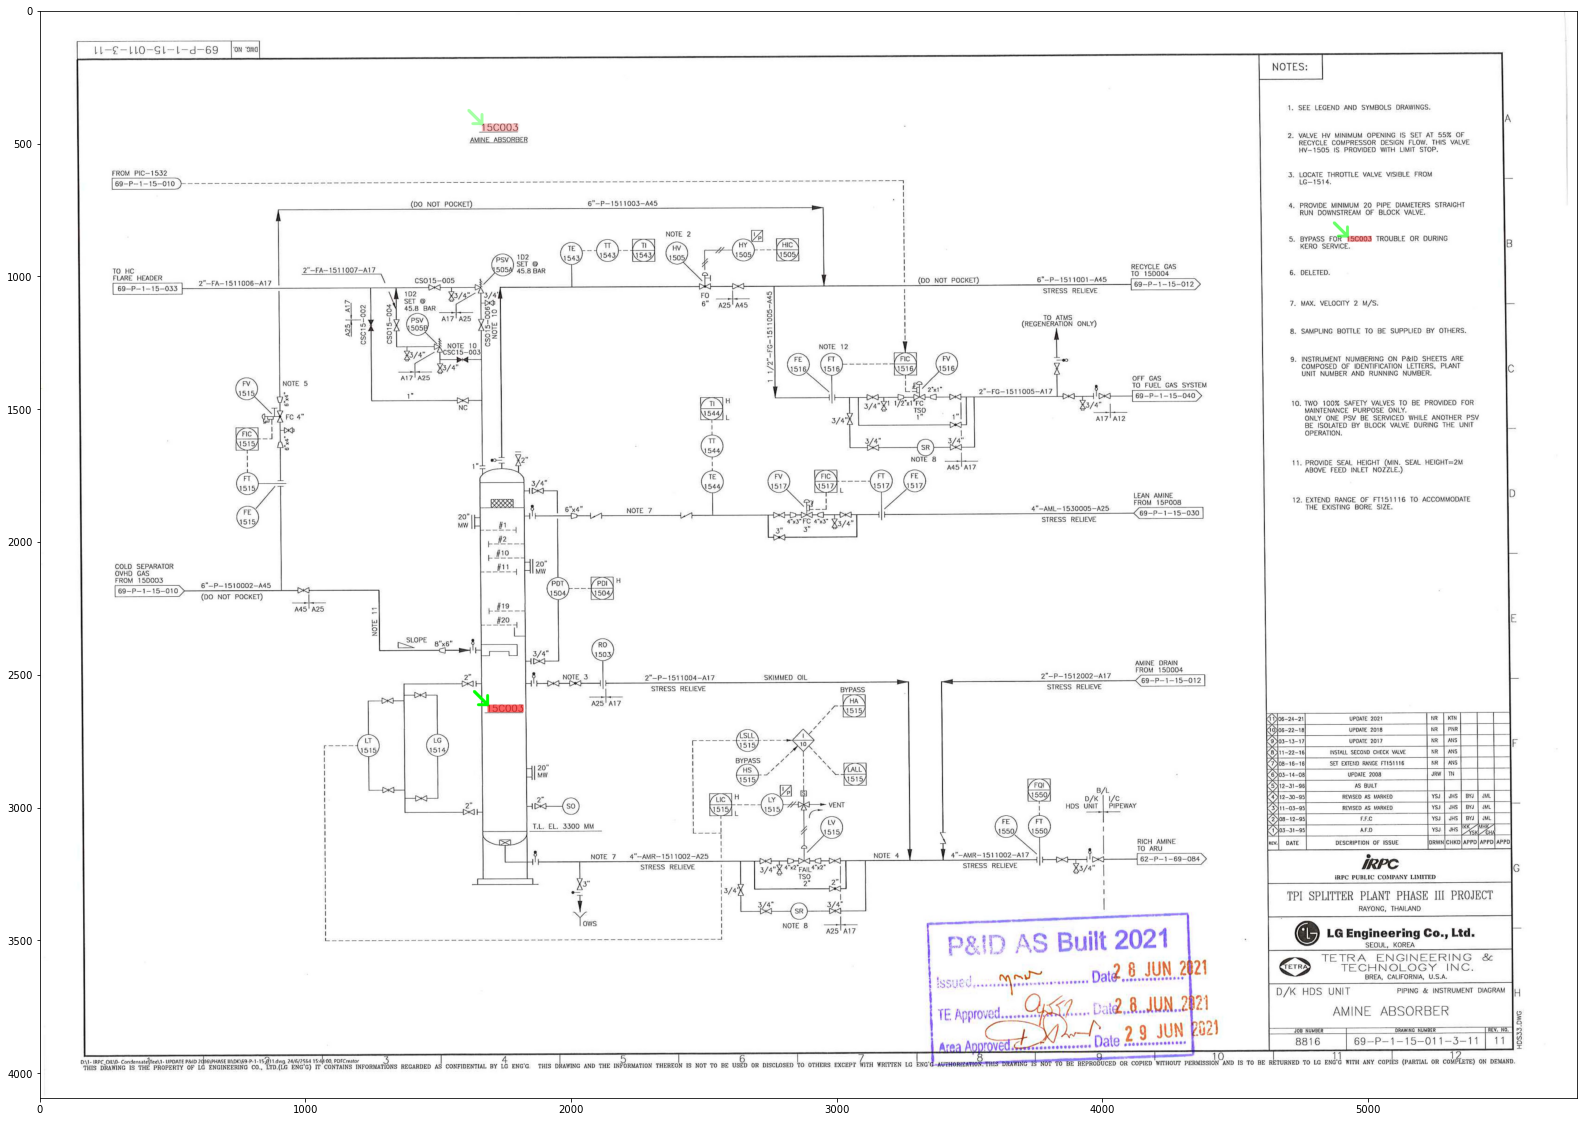

In [37]:
pic = 2
a = lookup_df[lookup_df.file_name==lookup_file_name[pic]].values
read_folder = r'./images/'
save_folder = r'./find/'
makedir(save_folder)
file = lookup_file_name[pic]
image = read_folder+lookup_file_name[pic]
img0 = cv2_imread_win(image,np)
img = img0.copy()
plt.figure(figsize=(30,20))
for fn,id,text,x1,y1,x2,y2 in tqdm_notebook(a):
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), -1)
    alpha = 0.6  # Transparency factor.
    # Following line overlays transparent rectangle over the image
    img = cv2.addWeighted(img, alpha, img0, 1 - alpha, 0)
    img = cv2.arrowedLine(img, (x1-50,y1-50), (x1,y1),
                                         color=(0, 255, 0), thickness=9, tipLength = 0.5)
    # print((x1, y1), (x2, y2))
    plt.imshow(img);
    # plt.show();
plt.imsave(save_folder+file,img)

In [233]:
img_new0 = cv2.arrowedLine(img_new, (x1-50,y1-50), (x1,y1),
                                         color=(0, 255, 0), thickness=9, tipLength = 0.5)

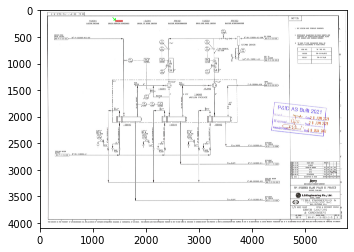

In [234]:
plt.imshow(img_new0)

In [ ]:
# https://betterprogramming.pub/highlighting-specific-word-in-an-input-image-1cf3d4f8ae27
# https://www.geeksforgeeks.org/python-opencv-cv2-arrowedline-method/
read_folder = r'./images/'
save_folder = r'./find'
image = read_folder+find_text(lookup=lookup).file_name.item()
file = find_text(lookup=lookup).file_name.item()
x1 = find_text(lookup=lookup).x1.item()
x2 = find_text(lookup=lookup).x2.item()
y1 = find_text(lookup=lookup).y1.item()
y2 = find_text(lookup=lookup).y2.item()
# crop_text = cv2_imread_win(image,np)[y1:y2,x1:x2]
def find_drawing(image,file,saved_folder):
    img0 = cv2_imread_win(image,np)
    img = img0.copy()
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), -1)
#     cv2.putText(img, find_text(lookup=lookup).text.item(), (x1, y2),cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
#     img[y1:y2,x1:x2] = crop_text
    alpha = 0.6  # Transparency factor.
    # Following line overlays transparent rectangle over the image
    img_new = cv2.addWeighted(img, alpha, img0, 1 - alpha, 0)
    img_new = cv2.arrowedLine(img_new, (x1-50,y1-50), (x1,y1),
                                     color=(0, 255, 0), thickness=9, tipLength = 0.5)
    plt.imsave(saved_folder+file,img_new)
    return(find_text(lookup=lookup))

In [180]:
find_drawing(image,file,save_folder)

NameError: name 'find_drawing' is not defined

In [2]:
######################################

In [98]:
read_folder = r'./images/'
print(read_folder+find_text(lookup=lookup).file_name.values)

['./images/19_08-P123001-3-AR2-Layout3-Layout1_page1.jpg']


In [101]:
find_text(lookup=lookup).x1.values

array([1699], dtype=int64)